<a href="https://colab.research.google.com/github/itsSrijan/whatsapp-chat-analysis/blob/main/lstm_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 7.1 MB/s 


In [3]:
import os
import copy
import itertools
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalMaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import cross_val_score
from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from scikeras.wrappers import KerasClassifier
# from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, classification_report

mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['axes.grid'] = False

Can be provided separetely

* Inputs
1. no. of samples in each frame = ns
2. joints/accelerometer which onw wants to analyse = j
3. filters = f1, f2
4. kernel_size = k
5. strides = s
6. learning_rate = lr
7. validation_split = vs
8. batch_size = b
9. epochs = e  

* Functions
1. takes **ns, j, (directory)** and returns **scaled_train, train_label, scaled_test, test_label**
2. takes 
3. takes **f, k, lr, s** and returns **model**
 

In [4]:
#Inputs

directory = '/content/drive/MyDrive/Dataset'
sampling_freq = 1024
duration = 256
nojoints = 30
nosamples = 64 #nosamples = [64, 128, 256, 512]
timesteps = 8
# strides = 1
# learning_rate = 0.001
# batch_size = 32
epochs = 100
# validation_split = 0.1

frames = (sampling_freq * duration)/(nosamples * timesteps)

In [5]:
frames

512.0

In [6]:
#here, we are reading the different .csv from the directory which contain the data

i = 0
DF = {} #this will contain the damaged frames for all joint
UFN = {} #this will contain undamaged shuffled frames for all joints joint
for filename in os.scandir(directory):
     if filename.is_file():
        i = i + 1 
        df = pd.read_csv(filename.path)
        if str(i) in filename.name:
            col = 'J' + str(i)
            key = 'DF'+ str(i)
            DF[key] = df[col] 
        for j in range(1, nojoints + 1):
            if j!=i:
              col = 'J' + str(j)
              key_UFN = 'UFN' + str(j)
              if key_UFN not in UFN:
                UFN[key_UFN] = []
              UFN[key_UFN].append(df[col])

for keys in DF:
  temp1 = np.array(DF[keys])
  temp2 = np.array(np.split(temp1,sampling_freq * duration / nosamples)) #splitting damaged dataset into frames
  DF[keys] = np.array(np.split(temp2, frames))

for keys in UFN:
  temp1 = np.array(UFN[keys])
  temp2 = np.reshape(temp1, temp1.shape[0] * temp1.shape[1])
  temp3 = np.array(np.split(temp2, sampling_freq * duration * nojoints / nosamples)) #splitting undamaged dataset into frames, each having 128 samples
  temp4 = np.array(np.split(temp3, temp3.shape[0] / timesteps))
  np.random.shuffle(temp4) #shuffling the undamaged frames
  UFN[keys] = temp4   #[:int(frames),:] #selecting first 'n' frames equal to no. of damaged frames

In [7]:
y1 = copy.deepcopy(UFN['UFN1'])
y2 = copy.deepcopy(DF['DF1'])


y1_label = np.zeros((y1.shape[0], 1))
y2_label = np.ones((y2.shape[0], 1))
# one_hot_label = to_categorical(input_labels)

# now, y1 contains 4096 undamaged frames and y2 contains 4096 damaged frames. In the paper, half of the frames from both undamaged and 
# damaged was used for training. 

# we will take 10% of from half of damaged and half of undamaged frames to create a validation set

 


y1_half = y1[:int(frames/2)]
y2_half = y2[:int(frames/2)]
y1_label_half = y1_label[:int(frames/2)]
y2_label_half = y2_label[:int(frames/2)]
train = np.concatenate((y1_half, y2_half), axis = 0)
train_label = np.concatenate((y1_label_half, y2_label_half), axis = 0)
train_label = np.reshape(train_label, (train_label.shape[0], 1))
train_label = to_categorical(train_label)
train, train_label = shuffle (train, train_label, random_state = 42)

# Here, we are using the remaining half for test purpose

y1_rem = y1[int(frames/2):int(frames)]
y2_rem = y2[int(frames/2):int(frames)]
y1_label_rem = y1_label[int(frames/2):int(frames)]
y2_label_rem = y2_label[int(frames/2):int(frames)]
test = np.concatenate((y1_rem, y2_rem), axis = 0)
test_label = np.concatenate((y1_label_rem, y2_label_rem), axis = 0)
test_label = np.reshape(test_label, (test_label.shape[0], 1))
test_label = to_categorical(test_label)
test, test_label = shuffle(test, test_label, random_state = 42)


In [8]:
# scaling the training and test data

scaler = StandardScaler()
scaled_train = scaler.fit_transform(train.reshape(-1, train.shape[-1])).reshape(train.shape)
scaled_test = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)

In [39]:
class MyHyperModel(kt.HyperModel):
  def build(self, hp):
    model = keras.Sequential()
    model.add(InputLayer(input_shape = (8,64)))
    for i in range(hp.Int('layers', 1, 6)): 
      model.add(LSTM(units = hp.Choice('units' + str(i+1),  [32, 64, 128, 512, 1024], ordered = False, default = 32), activation = 'tanh', return_sequences = True))
      model.add(Dropout(rate = hp.Float('rate' + str(i+1), 0.1, 0.2, 0.05)))
    model.add(Flatten())
    # model.add(Dropout(rate = hp.Float('rate', 0.1, 0.2, 0.05 )))
    model.add(Dense(units = hp.Choice('units', [8, 16, 32, 64], ordered = False)))
    
    model.add(Dense(units = 2, activation='softmax'))

    model.compile(optimizer = Adam(learning_rate = hp.Choice('learning_rate', [0.0003, 0.001, 0.01], ordered = False)), loss='binary_crossentropy', metrics = ['accuracy'])
    return model 

In [40]:
class MyTuner(BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', [32, 64, 128, 256])
    return super(MyTuner, self).run_trial(trial, *args, **kwargs)

In [41]:
tuner = MyTuner(
    MyHyperModel(), 
    objective ='val_loss', 
    max_trials = 20,
    overwrite = True,
    directory = '/content/drive/MyDrive/Colab Notebooks', 
    project_name = 'bo3')

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', 
    patience=20, 
    mode='min',
    restore_best_weights = True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Colab Notebooks',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [43]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units1 (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 512, 1024], 'ordered': False}
rate1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.2, 'step': 0.05, 'sampling': None}
units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32, 64], 'ordered': False}
learning_rate (Choice)
{'default': 0.0003, 'conditions': [], 'values': [0.0003, 0.001, 0.01], 'ordered': False}


In [44]:
tuner.search(scaled_train, train_label, validation_split = 0.2, epochs = 100, callbacks = [early_stopping]) #,  model_checkpoint

Trial 20 Complete [00h 00m 18s]
val_loss: 0.06471651047468185

Best val_loss So Far: 0.06471651047468185
Total elapsed time: 00h 12m 52s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [45]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/bo3
Showing 10 best trials
Trial summary
Hyperparameters:
layers: 1
units1: 1024
rate1: 0.1
units: 64
learning_rate: 0.0003
batch_size: 32
units2: 32
rate2: 0.1
units3: 1024
rate3: 0.15000000000000002
units4: 1024
rate4: 0.20000000000000004
units5: 1024
rate5: 0.20000000000000004
units6: 1024
rate6: 0.20000000000000004
Score: 0.06471651047468185
Trial summary
Hyperparameters:
layers: 1
units1: 1024
rate1: 0.1
units: 64
learning_rate: 0.0003
batch_size: 32
units2: 32
rate2: 0.1
units3: 32
rate3: 0.1
units4: 1024
rate4: 0.1
units5: 1024
rate5: 0.20000000000000004
units6: 1024
rate6: 0.20000000000000004
Score: 0.06923691928386688
Trial summary
Hyperparameters:
layers: 1
units1: 1024
rate1: 0.1
units: 8
learning_rate: 0.0003
batch_size: 32
units2: 32
rate2: 0.1
units3: 1024
rate3: 0.15000000000000002
units4: 1024
rate4: 0.1
units5: 1024
rate5: 0.20000000000000004
units6: 1024
rate6: 0.20000000000000004
Score: 0.0774386525154

In [46]:
best_params = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_params.values

{'batch_size': 32,
 'layers': 1,
 'learning_rate': 0.0003,
 'rate1': 0.1,
 'rate2': 0.1,
 'rate3': 0.15000000000000002,
 'rate4': 0.20000000000000004,
 'rate5': 0.20000000000000004,
 'rate6': 0.20000000000000004,
 'units': 64,
 'units1': 1024,
 'units2': 32,
 'units3': 1024,
 'units4': 1024,
 'units5': 1024,
 'units6': 1024}

In [48]:
tuner.get_best_models(num_models = 1)[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 1024)           4460544   
                                                                 
 dropout (Dropout)           (None, 8, 1024)           0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 4,985,026
Trainable params: 4,985,026
Non-trainable params: 0
_________________________________________________________________


In [50]:
model = tuner.hypermodel.build(best_params)
history = model.fit(scaled_train, train_label, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/50
13/13 [==============================] - 2s 47ms/step - loss: 0.6953 - accuracy: 0.5428 - val_loss: 0.6792 - val_accuracy: 0.5825
Epoch 2/50
13/13 [==============================] - 0s 15ms/step - loss: 0.5629 - accuracy: 0.7359 - val_loss: 0.5985 - val_accuracy: 0.6408
Epoch 3/50
13/13 [==============================] - 0s 12ms/step - loss: 0.3722 - accuracy: 0.8680 - val_loss: 0.3506 - val_accuracy: 0.8932
Epoch 4/50
13/13 [==============================] - 0s 11ms/step - loss: 0.1263 - accuracy: 0.9682 - val_loss: 0.2007 - val_accuracy: 0.9029
Epoch 5/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0388 - accuracy: 0.9853 - val_loss: 0.1333 - val_accuracy: 0.9320
Epoch 6/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0558 - accuracy: 0.9756 - val_loss: 0.1332 - val_accuracy: 0.9709
Epoch 7/50
13/13 [==============================] - 0s 10ms/step - loss: 0.0664 - accuracy: 0.9756 - val_loss: 0.2433 - val_accuracy: 0.9320
Epoch 8/50
13

In [ ]:
hypermodel = tuner.hypermodel.build(best_params)

# Retrain the model
hypermodel.fit(scaled_train, train_label, epochs=best_epoch, validation_split=0.2)

Epoch 1/6
13/13 [==============================] - 4s 70ms/step - loss: 0.4011 - accuracy: 0.7995 - val_loss: 0.1036 - val_accuracy: 0.9612
Epoch 2/6
13/13 [==============================] - 0s 9ms/step - loss: 0.0678 - accuracy: 0.9804 - val_loss: 0.0668 - val_accuracy: 0.9806
Epoch 3/6
13/13 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9951 - val_loss: 0.2511 - val_accuracy: 0.9417
Epoch 4/6
13/13 [==============================] - 0s 8ms/step - loss: 0.0278 - accuracy: 0.9927 - val_loss: 0.3897 - val_accuracy: 0.9515
Epoch 5/6
13/13 [==============================] - 0s 8ms/step - loss: 0.0314 - accuracy: 0.9902 - val_loss: 0.2734 - val_accuracy: 0.9515
Epoch 6/6
13/13 [==============================] - 0s 10ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.2306 - val_accuracy: 0.9417


In [51]:
hypermodel = tuner.hypermodel.build(best_params)

# Retrain the model
hypermodel.fit(scaled_train, train_label, epochs=best_epoch, validation_split=0.2, verbose = 10)

Epoch 1/6
Epoch 2/6
Epoch 3/6
Epoch 4/6
Epoch 5/6
Epoch 6/6


In [59]:
MyHyperModel.build(hypermodel, best_params)

# Retrain the model
hypermodel.fit(scaled_train, train_label, epochs=best_epoch, validation_split=0.2, verbose = 2)

Epoch 1/6
13/13 - 0s - loss: 1.7604e-04 - accuracy: 1.0000 - val_loss: 0.0576 - val_accuracy: 0.9709 - 283ms/epoch - 22ms/step
Epoch 2/6
13/13 - 0s - loss: 1.5995e-04 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9709 - 169ms/epoch - 13ms/step
Epoch 3/6
13/13 - 0s - loss: 1.4393e-04 - accuracy: 1.0000 - val_loss: 0.0584 - val_accuracy: 0.9709 - 161ms/epoch - 12ms/step
Epoch 4/6
13/13 - 0s - loss: 1.3373e-04 - accuracy: 1.0000 - val_loss: 0.0583 - val_accuracy: 0.9709 - 205ms/epoch - 16ms/step
Epoch 5/6
13/13 - 0s - loss: 1.2102e-04 - accuracy: 1.0000 - val_loss: 0.0585 - val_accuracy: 0.9709 - 193ms/epoch - 15ms/step
Epoch 6/6
13/13 - 0s - loss: 1.0922e-04 - accuracy: 1.0000 - val_loss: 0.0590 - val_accuracy: 0.9709 - 176ms/epoch - 14ms/step


In [60]:
eval_result = hypermodel.evaluate(scaled_test, test_label)
print("[test loss, test accuracy]:", eval_result)

16/16 [==============================] - 0s 5ms/step - loss: 0.0550 - accuracy: 0.9824
[test loss, test accuracy]: [0.0549764558672905, 0.982421875]


In [109]:
predictions = hypermodel.predict(DF['DF2'], verbose = 1)
predictions.shape

16/16 [==============================] - 0s 4ms/step


(512, 2)

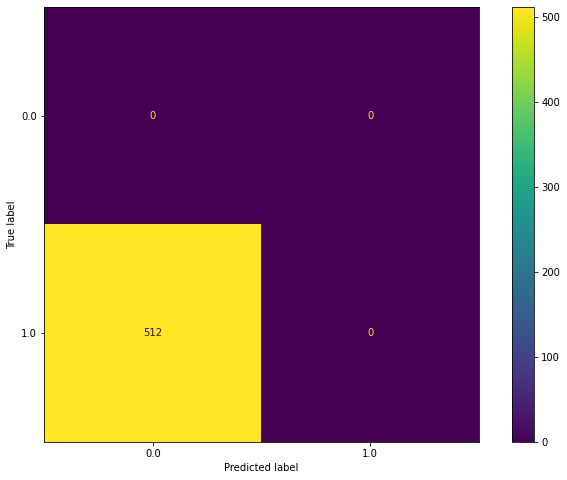

In [110]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions((np.ones(shape = (predictions.shape[0], 1))),np.round(predictions).argmax(axis = 1)) #test_label.argmax(axis = 1) 
plt.show()

In [106]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [101]:
to_categorical(np.zeros(shape = (predictions.shape[0], 1)))

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [9]:
# train_generator = TimeseriesGenerator(scaled_train, train_label, length = timesteps, stride = timesteps, batch_size = 1,sampling_rate = 1)
# test_generator = TimeseriesGenerator(scaled_test, test_label, length = timesteps, stride = timesteps, batch_size = 1, sampling_rate = 1)

In [10]:
# def LSTM_classifier():

#   model = Sequential()
#   model.add(LSTM(units = 64 , activation='tanh', input_shape=(timesteps, nosamples), return_sequences=True))
#   model.add(Dropout(rate = 0.2))
#   model.add(LSTM(units = 128, activation='tanh', return_sequences=True))
#   model.add(Dropout(rate = 0.2))
#   model.add(LSTM(units = 64, activation='tanh', return_sequences=False))
#   model.add(Dropout(rate = 0.2))
#   model.add(Flatten())
#   model.add(Dense(units = 32))
#   model.add(Dropout(rate = 0.2))
#   model.add(Dense(units = 2, activation = 'softmax'))
#   model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
#   return model



In [11]:
# # timesteps = [2, 4, 8, 16] timesteps = timesteps,
# # nolayers = [1, 2, 3, 4, 5, 6] nolayers = nolayers
# units = [1024, 512, 256, 128, 64, 32]
# rate = [0.2, 0.5]
# learning_rate = [0.0003, 0.001, 0.01]
# batch_size = [64, 256, 512]
# nodes = (
#     list(itertools.product(units, repeat=1))
#     + list(itertools.product(units, repeat=2))
#     + list(itertools.product(units, repeat=3))
#     + list(itertools.product(units, repeat=4))
#     + list(itertools.product(units, repeat=5))
#     + list(itertools.product(units, repeat=6))
# )

# param_grid = dict(  nodes = nodes, rate = rate, learning_rate = learning_rate, batch_size = batch_size, units = units)

In [12]:
# def build_model(hp):
#   model = keras.Sequential()
#   model.add(InputLayer(input_shape = (8,64)))
#   for i in range(hp.Int('layers', 1, 6)): 
#       model.add(LSTM(units = hp.Int('units' + str(i+1), 32, 1024, 32), activation = 'tanh', return_sequences = True, dropout = hp.Choice('rate' + str(i+1), [0.2, 0.5], ordered = False)))
#   model.add(Flatten())
#   model.add(Dense(units = hp.Choice('units', [16, 32, 64], ordered = False)))
#   model.add(Dropout(rate = hp.Choice('rate', [0.2, 0.5], ordered = False)))
#   model.add(Dense(units = 2, activation='softmax'))

#   model.compile(optimizer = Adam(learning_rate = hp.Choice('learning_rate', [0.0003, 0.001, 0.01], ordered = False)), loss='binary_crossentropy', metrics = ['accuracy'])
#   return model


In [ ]:
class Employee:
  def __init__(self, pay):
    self.pay = pay

  def Max(self):
    max_pay = 2 * self.pay
    return max_pay

  def MaxMax(self):
    return Employee.Max(self) * 3

In [ ]:
emp1 = Employee(5)
emp1.MaxMax()

30

In [ ]:
def layer_creation(model, nodes, rate, timesteps, nosamples):
  for x in tf.range(len(nodes)):
    if x == 0:
      model.add(LSTM(units = nodes[x], activation = 'tanh', input_shape=(timesteps, nosamples), return_sequences = True))
      model.add(Dropout(rate = rate))
    elif x == len(nodes) - 1:
      model.add(LSTM(units = nodes[x], activation = 'tanh', return_sequences = False))
      model.add(Dropout(rate = rate))
    else:
      model.add(LSTM(units = nodes[x], activation = 'tanh', return_sequences = True))
      model.add(Dropout(rate = rate))
  return model

In [ ]:
# def LSTM_classifier(nodes, units, rate, learning_rate, timesteps = 8, nosamples = 64):

#   model = Sequential()

#   layer_creation(model, nodes, rate, timesteps, nosamples)
  
#   model.add(Flatten())
  
#   model.add(Dense(units = units))
  
#   model.add(Dropout(rate = rate))

#   model.add(Dense(units = 2, activation = 'softmax'))

#   model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
  
#   return model

# model = KerasClassifier(model = LSTM_classifier, verbose = 0)

# model = KerasClassifier(model = LSTM_classifier, units = None, rate = None, nodes = None, learning_rate = None, batch_size = None, verbose = 0)

# def hypertuning_lstm(estimator, param_distributions, n_iter, cv, X, y):
#   rscv = RandomizedSearchCV(estimator = estimator, param_distributions = param_distributions, n_iter = n_iter, cv = cv, scoring = roc_auc_score(estimator, scaled_test, test_label))
#   rscv.fit(X, y)
#   ht_params = rscv.best_params_
#   ht_score = rscv.best_score_

#   return ht_params, ht_score

# lstm_parameters, lstm_score = hypertuning_lstm(estimator = model, param_distributions = param_grid, cv = 3, X = scaled_train, y = train_label, n_iter = 60)
# print(lstm_parameters, lstm_score)

  # model = Sequential()
  # model.add(LSTM(units = 64 , activation='tanh', input_shape=(timesteps, nosamples), return_sequences=True))
  # model.add(Dropout(rate = 0.2))
  # model.add(LSTM(units = 128, activation='tanh', return_sequences=True))
  # model.add(Dropout(rate = 0.2))
  # model.add(LSTM(units = 64, activation='tanh', return_sequences=False))
  # model.add(Dropout(rate = 0.2))
  # model.add(Flatten())
  # model.add(Dense(units = 32))
  # model.add(Dropout(rate = 0.2))
  # model.add(Dense(units = 2, activation = 'softmax'))
  # model.compile(optimizer = Adam(learning_rate = learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # return model

In [ ]:
# model = KerasClassifier(build_fn = LSTM_classifier, batch_size = batch_size, epochs = epochs)
# accuracies = cross_val_score(estimator = model, X = train, y = train_label, cv = KFold(3), n_jobs = -1)
# np.mean(accuracies)
# from sklearn.metrics import make_scorer
# from sklearn.metrics import accuracy_score, precision_score, recall_score
# score = make_scorer(accuracy_score)
# kfold_validation = KFold(3)
# results = cross_val_score(model, train, train_label, cv = kfold_validation, scoring = score)
# print(results)
# print(np.mean(results))

In [ ]:
model.fit(train, train_label, validation_split = 0.1,  batch_size = 64, epochs = epochs, verbose = 2, callbacks = [early_stopping])

In [ ]:
predictions = model.predict(test, verbose = 1)
predictions.shape

In [ ]:
# q = np.concatenate((test_label[1:256], test_label[2048:2048+256]), axis = 0)

We can use ROC curve to find the **threshhold** that will give maximum accuracy i.e when **TPR** (True Positive Rate) is almost equal to **TNR** (True Negative Rate)

With threshold = 0.5, **TPR** = 244/(244 + 12) i.e. **0.953** and **TNR** = 247/(247 + 8) i.e. **0.968**

In [ ]:
weights_binary = model.get_weights()

In [ ]:
# train_generator[0][0].shape

In [ ]:
# train_generator[510][0]

In [ ]:
predictions

In [ ]:
np.count_nonzero(test_label.argmax(axis = 1))